In [7]:
import os
from typing import Callable, Tuple

from matplotlib import pyplot as plt
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from common import ModelManager

class LeNet5(nn.Module):
    def __init__(self) -> None:
        super(LeNet5, self).__init__()
        self._feature_extraction: nn.Sequential = nn.Sequential(
            # Input image shape should be 32x32x1
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),      # 28x28x6
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),                                  # 14x14x6
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),     # 10x10x16
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),                                  # 5x5x16
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),   # 1x1x120
            nn.Tanh(),
        )

        self._classifier: nn.Sequential = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=10),
        )
    
    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        x = self._feature_extraction(x)
        x = torch.flatten(x, 1)
        logits = self._classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs


def show_results(
    model: nn.Module,
    dataset: datasets.MNIST,
    img_per_row: int,
    n_rows: int
) -> None:
    fig: plt.Figure = plt.figure()
    for i in range(1, n_rows * img_per_row + 1):
        plt.subplot(img_per_row, n_rows, i)
        plt.axis("off")
        plt.imshow(dataset.data[i], cmap="gray_r")

        with torch.no_grad():
            model.eval()
            _, probs = model(dataset[i][0].unsqueeze(0))
        title: str = f"{torch.argmax(probs)} ({torch.max(probs * 100):.0f}%)"
        plt.title(title, fontsize=7)
    fig.suptitle("LeNet5 - predictions")


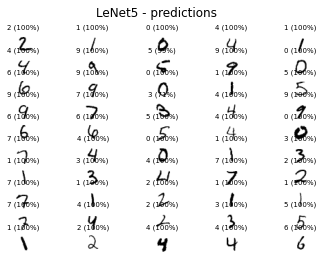

In [9]:
if __name__ == "__main__":
    RANDOM_SEED = 42
    LEARNING_RATE = 0.001
    BATCH_SIZE = 32
    N_EPOCHS = 15

    IMG_SIZE = (32, 32)

    data_path: str = os.path.join("resources", "datasets", "mnist")
    os.makedirs(data_path, exist_ok=True)
    model_path: str = os.path.join("resources", "models", "lenet5-mnist.pth")
    
    data_transform: Callable = transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
    ])

    train_data: datasets.MNIST = datasets.MNIST(
        root=data_path,
        train=True,
        transform=data_transform,
        download=True,
    )
    test_data: datasets.MNIST = datasets.MNIST(
        root=data_path,
        train=False,
        transform=data_transform,
        download=True,
    )

    train_data_loader: DataLoader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
    test_data_loader: DataLoader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

    model_manager: ModelManager = ModelManager(
        model=LeNet5(),
        loss_fn=nn.CrossEntropyLoss(),
        optimizer=optim.Adam,
        hyperparameters=dict(
            lr=LEARNING_RATE,
        )
    )

    if not os.path.isfile(model_path):
        model_manager.run_train_loop(
            train_data_loader=train_data_loader,
            test_data_loader=test_data_loader,
            epochs=N_EPOCHS,
        )
        model_manager.save_parameters(model_path)
    else:
        model_manager.load_parameters(model_path)
    
    show_results(model_manager.model, test_data, 10, 5)
